<a href="https://colab.research.google.com/github/lanej5/mlb/blob/main/elo/ELO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ELO ratings for baseball

> "A quick post where I build a basic ELO rating system for major league baseball."

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [ELO ratings, data science]
- hide: false
- search_exclude: false

One goal of my ongoing [mlb dashboard](https://github.com/lanej5/mlb) project is to add forecasts. A simple way to do this is to build an [ELO rating model](https://en.wikipedia.org/wiki/Elo_rating_system) and use ratings to make predictions. In fact, 538 [predicts mlb games this way](https://fivethirtyeight.com/features/how-our-mlb-predictions-work/). 

In this notebook I draft up a basic ELO model. In the process I show how the ELO model can be derived as MLE with online gradient descent. I found this interpretation insightful because most references don't describe ELO in these familiar ML terms. 

At the end we explore the quality of our ELO model's predictions. It turns out they aren't very good. In the next post we'll try to add some features and make a better model.

# Notebook setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

I previously scraped MLB records for all teams from 1990 to 2020 from fangraphs using the `pybaseball` package (so nice when someone has done the work of writing the scraping scripts for you!).

In [2]:

# records of individual teams for each season have been scraped and stored
# let's load 'em up
from os import listdir
from os.path import isfile, join
path = "/content/drive/My Drive/mlb/previous_seasons/"
filenames = [f for f in listdir(path) if isfile(join(path, f))]
data = {}

for filename in filenames:
    year, team = int(filename[:4]), filename[5: 8]
    data[(year, team)] = pd.read_parquet(path + filename)

# Prepare data

We will need the data in a particular format. Let's process those dataframes.

In [3]:

# take a peek at the data
data[(1990, 'BAL')].head()

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled
1,"Monday, Apr 9",BAL,@,KCR,W,7.0,6.0,11.0,1-0,1.0,Tied,Aldrich,Montgomery,Olson,3:31,D,37671.0,1.25,1,None
2,"Wednesday, Apr 11",BAL,@,KCR,L,1.0,2.0,9.0,1-1,2.0,1.5,Gubicza,Ballard,Davis,2:51,N,18892.0,1.30,-1,None
3,"Friday, Apr 13",BAL,@,DET,L,6.0,10.0,9.0,1-2,5.0,1.5,Morris,Price,None,3:25,N,11871.0,1.45,-2,None
4,"Saturday, Apr 14",BAL,@,DET,W,7.0,4.0,9.0,2-2,3.0,1.0,Johnson,Ritz,Olson,3:36,D,11294.0,1.31,1,None
5,"Sunday, Apr 15",BAL,@,DET,L,4.0,6.0,9.0,2-3,4.0,1.5,Petry,Aldrich,Henneman,3:03,D,10632.0,1.53,-1,None


In [4]:
#hide
data[(1990, 'BAL')].dtypes

Date                object
Tm                  object
Home_Away           object
Opp                 object
W/L                 object
R                  float64
RA                 float64
Inn                float64
W-L                 object
Rank               float64
GB                  object
Win                 object
Loss                object
Save                object
Time                object
D/N                 object
Attendance         float64
cLI                 object
Streak               int64
Orig. Scheduled     object
dtype: object

In [5]:

# clean the dates
from datetime import datetime
from calendar import month_abbr

months = {abbr: i + 1 for i, abbr in enumerate(month_abbr[1:])}

for (year, team) in data.keys():
    data[(year, team)]['Date'] = data[(year, team)]['Date'].str.split(' ') \
    .apply(lambda x: pd.Timestamp(datetime(year, months[x[1]], int(x[2]))))

In [6]:
#hide
data[(1990, 'BAL')].head()

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled
1,1990-04-09,BAL,@,KCR,W,7.0,6.0,11.0,1-0,1.0,Tied,Aldrich,Montgomery,Olson,3:31,D,37671.0,1.25,1,None
2,1990-04-11,BAL,@,KCR,L,1.0,2.0,9.0,1-1,2.0,1.5,Gubicza,Ballard,Davis,2:51,N,18892.0,1.30,-1,None
3,1990-04-13,BAL,@,DET,L,6.0,10.0,9.0,1-2,5.0,1.5,Morris,Price,None,3:25,N,11871.0,1.45,-2,None
4,1990-04-14,BAL,@,DET,W,7.0,4.0,9.0,2-2,3.0,1.0,Johnson,Ritz,Olson,3:36,D,11294.0,1.31,1,None
5,1990-04-15,BAL,@,DET,L,4.0,6.0,9.0,2-3,4.0,1.5,Petry,Aldrich,Henneman,3:03,D,10632.0,1.53,-1,None


In [7]:
seasons = {s for (s, t) in data.keys()}
teams = {season: [t for (s, t) in data.keys() if s == season] for season in seasons}

min(seasons), max(seasons)

(1990, 2020)

In [8]:

# concatenate home games from each team and sort by date
home_records = [
    data[(season, team)][data[(season, team)]['Home_Away'] == 'Home']
    for season in seasons
    for team in teams[season]
]

games = pd.concat(home_records, axis=0).sort_values(by=['Date']).reset_index().drop(columns=['index'])
games

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled
0,1990-04-09,TEX,Home,TOR,W,4.0,2.0,9.0,1-0,1.0,Tied,Ryan,Stottlemyre,Russell,3:07,N,40907.0,1.26,1.0,1990-04-03 (Strike)
1,1990-04-09,BOS,Home,DET,W,5.0,2.0,9.0,1-0,1.0,Tied,Clemens,Morris,Smith,2:47,D,35199.0,1.41,1.0,None
2,1990-04-09,KCR,Home,BAL,L,6.0,7.0,11.0,0-1,5.0,1.0,Aldrich,Montgomery,Olson,3:31,D,37671.0,1.21,-1.0,None
3,1990-04-09,NYM,Home,PIT,L,3.0,12.0,9.0,0-1,5.0,1.0,Drabek,Gooden,None,3:18,D,47919.0,1.57,-1.0,None
4,1990-04-09,CAL,Home,SEA,L,4.0,7.0,9.0,0-1,5.0,1.0,Holman,Blyleven,Schooler,2:56,N,38406.0,1.47,-1.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71075,2020-09-27,CLE,Home,PIT,W,8.0,6.0,9.0,35-25,2.0,1.0,Karinchak,Turley,Hand,3:00,D,NaN,.60,1.0,None
71076,2020-09-27,STL,Home,MIL,W,5.0,2.0,9.0,30-28,2.0,3.0,Gallegos,Anderson,Reyes,2:58,D,NaN,1.45,1.0,None
71077,2020-09-27,CHW,Home,CHC,L,8.0,10.0,9.0,35-25,2.0,1.0,Alzolay,Lopez,Chafin,3:37,D,NaN,.84,-1.0,None
71078,2020-09-27,LAD,Home,LAA,W,5.0,0.0,9.0,43-17,1.0,up 6.0,May,Sandoval,None,2:54,D,NaN,.00,4.0,None


In [9]:

# did you know there can be ties in baseball?
# they're pretty rare though
games['W/L'].value_counts()

L       32813
W       31945
W-wo     6271
T          13
W &V       12
L &H       11
L &V        8
W &H        3
L-wo        2
L *V        1
W &X        1
Name: W/L, dtype: int64

In [10]:

# i'm not sure whatt some of these other 'W/L' values mean
# but at least they seem to represent wins and losses
games[games['W/L'] == 'W &H']

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled
5425,1992-07-22,MIL,Home,TEX,W &H,4.0,1.0,9.0,50-43,3.0,6.5,Navarro,Brown,None,2:19,D,27095.0,1.01,1.0,None
30124,2003-07-03,OAK,Home,SEA,W &H,5.0,2.0,9.0,48-36,2.0,6.0,Zito,Franklin,Foulke,2:43,D,19612.0,1.69,1.0,None
43420,2008-09-26,SFG,Home,LAD,W &H,6.0,5.0,10.0,71-89,4.0,12.0,Walker,Johnson,None,3:33,N,33920.0,.00,1.0,None


In [11]:

import numpy as np

def f(x):
    if x[0] == 'W':
        return 1
    elif x[0] == 'L':
        return 0
    
    return np.nan

games['win'] = games['W/L'].apply(f)
games['win'].isna().sum()

13

In [12]:
#hide
# save the dataframe so we don't need to repeat this process
games.to_parquet("/content/drive/My Drive/mlb/games-1990-2020.parquet")

# ELO model

Let's review the math before we code it up. We describe the ELO system as MLE with online gradient descent. A similar but more detailed write-up is given in [this blog post](https://stmorse.github.io/journal/Elo.html).

## ELO Model

To each team $i$ we associate an ELO rating $\theta_i$. ELO ratings are the model's parameters. They represent relative strengths of teams.

Suppose team $i$ plays team $j$ and team $i$ is the home team. We label the game as $ y_{i,j} = 1$ if the home team wins, and $y_{i,j}=0$ if the home team loses. The first index in the subscript $i,j$ is always the home team.


The probability that the home team wins is modelled by a sigmoid function
$$ p_{i,j} = \sigma(a(\theta_i - \theta_j) + b) = \frac{1}{1 + e^{-a(\theta_i - \theta_j) - b}}.$$
The coefficients $a$ and $b$ are model hyperparameters. ELO uses a base 10 sigmoid function, which is just silly. I'm going to convert everything to base $e$ like a sane person.

In this simple version of the ELO model $b$ represents home advantage. If the historical probability the home team wins is $p$ then we can set 
$$ b = \ln \frac{p}{1 - p}$$
(set $\theta_i = \theta_j$ and solve for $b$).

## Learning

We learn our parameters using MLE and online gradient-descent. Let $\theta_i^t$ denote the rating of team $i$ at step $t$. Let $y_{i,j}^t$ denote the outcome of a game between team $i$ (home team) and team $j$ at step $t$. The log-likelihood of $y_{i,j}^t$ is 
$$L(y_{i,j}^t \mid \theta^t) =  \ln P(y_{i,j}^t \mid \theta^t) = y_{i,j}^t \ln p_{i,j}^t + (1 - y_{i,j}^t)\ln (1 - p_{i,j}^t) $$
where $p_{i,j}^t = \sigma(a (\theta_i^t - \theta_j^t) + b)$.

The gradient is
$$\nabla_\theta L(y_{i,j}^t \mid \theta^t) = y_{i,j}^t \nabla_\theta\ln p_{i,j}^t + (1 - y_{i,j}^t)\nabla_\theta\ln (1 - p_{i,j}^t)$$
$$ =  a y_{i,j}^t (1 - p_{i,j}^t)(\partial_{\theta_i} + \partial_{\theta_j}) + a(1 - y_{i,j}^t)p_{i,j}^t(\partial_{\theta_i} - \partial_{\theta_j}) $$
$$ = a(y_{i,j}^t - p_{i,j}^t)\frac{\partial}{\partial\theta_i} + a(p_{i,j}^t - y_{i,j}^t)\frac{\partial}{\partial\theta_j}.$$
This gradient makes sense in terms of the application too. If the result was anticipated with the current model parameters ($y_{i,j}^t \approx p_{i,j}^t$) then the gradient will be small. Conversely, if the result was not anticipated by the model parameters ($y_{i,j}^t - p_{i,j}^t \approx 1$) then the gradient will be large.  The rating of the winning team always increases and the rating of the losing team always decreases.

After such a game, the online gradient update is
$$ \theta_i^{t+1} = \theta_i^{t} + ka(y_{i,j}^t - p_{i,j}^t),$$
$$ \theta_j^{t+1} = \theta_j^{t} + ka(p_{i,j}^t - y_{i,j}^t).$$
The parameter $k$ is the learning rate, a hyperparameter to be tuned.

In implementation we absorb $a$ into the learning rate $k$.

## The model

In [13]:
from math import exp, sqrt, log
from datetime import timedelta
from typing import Tuple

def sigmoid(x):
    """Numerically stable sigmoid."""
    if x >= 0:
        return 1 / (1 + exp(-x))
    else:
        return exp(x) / (1 + exp(x))

class ELO():
    """Basic ELO rating model."""
    def __init__(self, a: float, b: float, k: float=1000) -> None:
        """Initialize the model.

        Args:
            k: learning rate
            a: linear coefficient
            b: y intercept (home advantage)
        """
        self.k = k
        self.a = a
        self.b = b
    
    def train(self, training_data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Run the training loop.

        Args:
            training_data: dataframe of game records

        Returns:
            elo: dataframe of elo rating dynamics for each team
            results: training data with 
        """
        teams = training_data['Tm'].unique().tolist()
        dates = pd.Series(training_data['Date'].unique()).sort_values()

        game_records = training_data[['Date','Tm','Opp','R','RA','win']].to_records(index=False)

        starting_date = training_data['Date'].iloc[0]
        initial_date = starting_date - timedelta(days=1)
        initial_elo = 1500

        # dict to store elo rating of teams
        elo = {team: [(initial_date, initial_elo)] for team in teams}

        results = []

        for date, home, away, r, ra, y in game_records:

            run_diff = abs(r - ra)

            # get previous ratings
            (home_date, home_rating), (away_date, away_rating) = elo[home][-1], elo[away][-1]

            # compute probability that home team wins
            p = sigmoid(self.a * (home_rating - away_rating) + self.b)

            # compute new ratings for both teams
            if not np.isnan(y):
                rf = log(run_diff) + 1 # modify learning rate by run differential
                new_home_rating = home_rating + rf * self.k * (y - p)
                new_away_rating = away_rating + rf * self.k * (p - y)

            # log the results
            elo[home].append((date, new_home_rating))
            elo[away].append((date, new_away_rating))
            results.append((p, home_rating, away_rating, new_home_rating, new_away_rating))
        
        
        results_df = pd.DataFrame(results, columns=['p', 'home_rating', 'away_rating', 'new_home_rating', 'new_away_rating'])

        elo_df = pd.DataFrame(index=dates)
        for team, team_ratings in elo.items():
            s = pd.DataFrame(team_ratings, columns=['Date', team]).set_index('Date')
            elo_df = pd.merge(
                elo_df,
                s,
                how='left',
                left_index=True,
                right_index=True
            )

        return elo_df, results_df

Before we run the model we need to select hyperparamters.

For $b$ we can use the historical home advantage.

In [14]:

# calculate the hyperparameter b from historical data
p_home = games['win'].mean()
b = log(p_home / (1 - p_home))
p_home, b

(0.5379712102663684, 0.15217784163292128)

For $a$ we use the same factor as Elo, but we change to base $e$.

For $k$ it is reported in various places that $4$ is a good value, so let's use that.

In [15]:
a = log(10) / 400 # this is 
k = 4

Now we can train the model.

In [16]:

# train the model
elo_model = ELO(a=a, b=b, k=k)

elo, results = elo_model.train(games)

results = pd.concat([games.copy(), results], axis=1)
results = results[~results['win'].isna()]

In [17]:
results.head()

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,...,Attendance,cLI,Streak,Orig. Scheduled,win,p,home_rating,away_rating,new_home_rating,new_away_rating
0,1990-04-09,TEX,Home,TOR,W,4.0,2.0,9.0,1-0,1.0,...,40907.0,1.26,1.0,1990-04-03 (Strike),1.0,0.537971,1500.0,1500.0,1503.129131,1496.870869
1,1990-04-09,BOS,Home,DET,W,5.0,2.0,9.0,1-0,1.0,...,35199.0,1.41,1.0,None,1.0,0.537971,1500.0,1500.0,1503.878477,1496.121523
2,1990-04-09,KCR,Home,BAL,L,6.0,7.0,11.0,0-1,5.0,...,37671.0,1.21,-1.0,None,0.0,0.537971,1500.0,1500.0,1497.848115,1502.151885
3,1990-04-09,NYM,Home,PIT,L,3.0,12.0,9.0,0-1,5.0,...,47919.0,1.57,-1.0,None,0.0,0.537971,1500.0,1500.0,1493.119941,1506.880059
4,1990-04-09,CAL,Home,SEA,L,4.0,7.0,9.0,0-1,5.0,...,38406.0,1.47,-1.0,None,0.0,0.537971,1500.0,1500.0,1495.484028,1504.515972


# How good is the model for making predictions?

Suppose we want to use the probabilities output by our simple ELO model to predict game outcomes. How well would that work?

Let's start by looking at the distribution of probabilities output by the model for wins and losses.

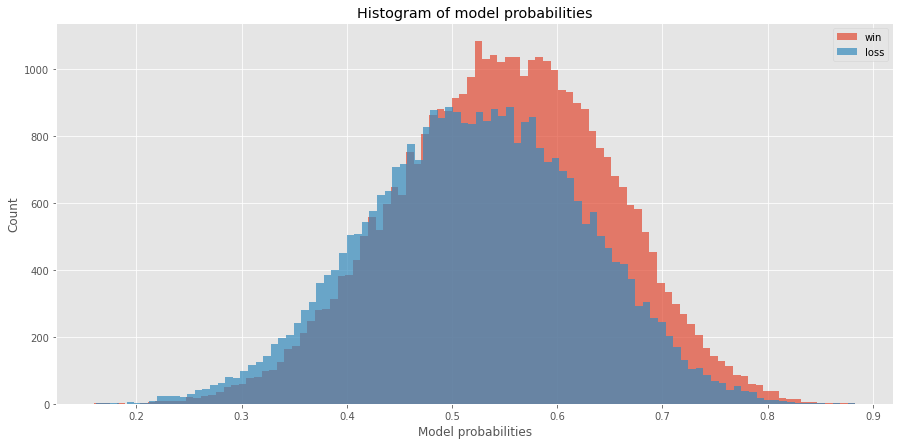

In [34]:
#hide_input
import matplotlib.pyplot as plt

plt.style.use('ggplot')

p_win = results.loc[results['win'] == 1, 'p']
p_loss = results.loc[results['win'] == 0, 'p']

plt.figure(figsize=(15,7))

plt.hist(p_win, alpha=.7, label='win', bins=100)
plt.hist(p_loss, alpha=.7, label='loss', bins=100)

plt.xlabel("Model probabilities")
plt.ylabel("Count")
plt.title('Histogram of model probabilities')
plt.legend(loc='upper right')
plt.show()

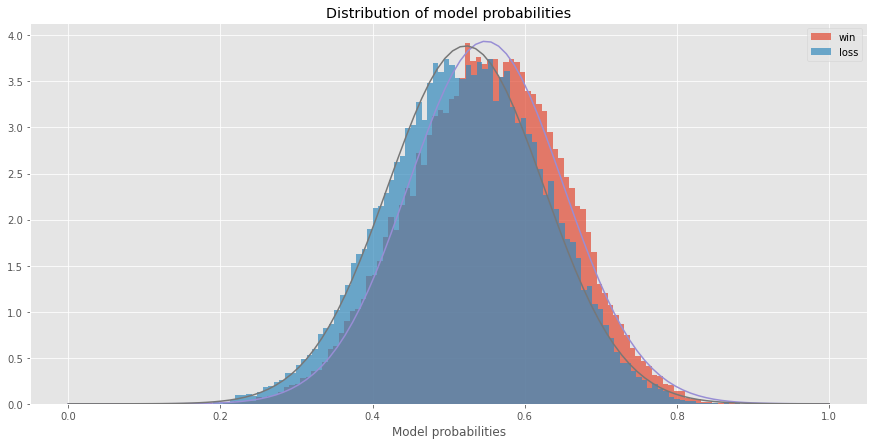

In [35]:
#hide_input
from scipy.stats import norm

(mu_win, sigma_win) = norm.fit(p_win)
(mu_loss, sigma_loss) = norm.fit(p_loss)


plt.figure(figsize=(15,7))

plt.hist(p_win, alpha=.7, label='win', bins=100, density=True)
plt.hist(p_loss, alpha=.7, label='loss', bins=100, density=True)

x = np.linspace(0, 1, 100)
y_win = norm(mu_win, sigma_win).pdf(x) #* len(p_win) * .01
y_loss = norm(mu_loss, sigma_loss).pdf(x) #* len(p_loss) * .01
l_win = plt.plot(x, y_win)
l_loss = plt.plot(x, y_loss)

plt.xlabel("Model probabilities")
plt.title('Distribution of model probabilities')
plt.legend(loc='upper right')
plt.show()

This doesn't seem promising. Whatever threshold we choose, the accuracy isn't going to be great.  ROC tells a similar story.

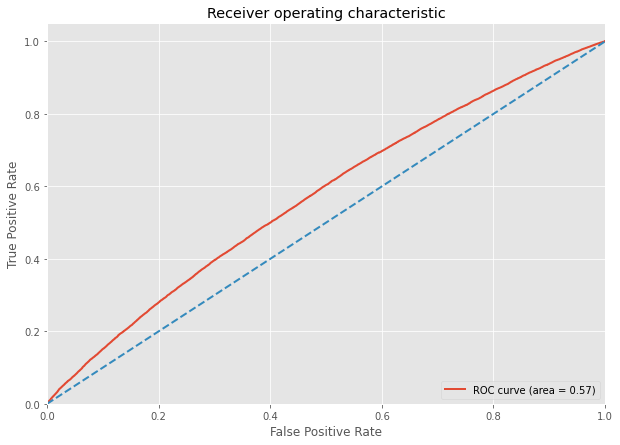

In [19]:
#hide_input
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(results['win'], results['p'], pos_label=1)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,7))
lw = 2
plt.plot(
    fpr,
    tpr,
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

Let's use LDA model to pick a threshold.

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = np.expand_dims(results['p'].to_numpy(), axis=1)
y = results['win']

clf = LinearDiscriminantAnalysis()
clf.fit(X, y)

results['pred'] = clf.predict(X)

Usurprisingly, the decision boundary of our LDA model is the probability the home team wins.

In [41]:
decision_boundary = clf.means_.sum() / 2
decision_boundary, p_home

(0.5356155745333546, 0.5379712102663684)

We can inspect the predictions at this threshold by looking at the confusion matrix.

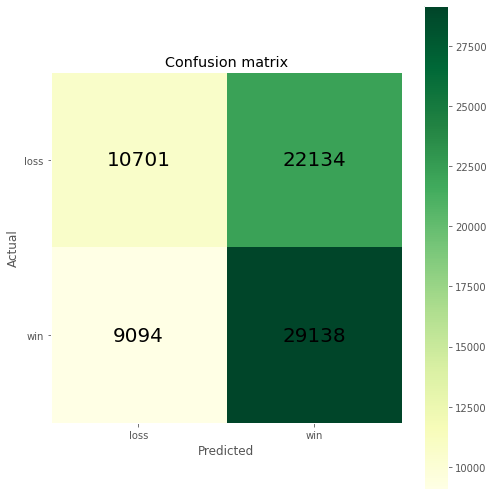

In [21]:
#hide_input
import matplotlib
from sklearn.metrics import confusion_matrix

plt.rcParams["axes.grid"] = False

c = confusion_matrix(results['win'], results['pred'], labels=[0, 1])


fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(c, cmap="YlGn")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['loss', 'win'])
ax.set_yticks(np.arange(2))
ax.set_yticklabels(['loss', 'win'])
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# Loop over data dimensions and create text annotations.
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, c[i, j],
                       ha="center", va="center", color="k", fontsize=20)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("", rotation=-90, va="bottom")

ax.set_title("Confusion matrix")
fig.tight_layout()
plt.show()

The accuracy we end up with is only marginally better than if we predicted the home team won every game.

In [22]:
from sklearn.metrics import accuracy_score

accuracy_score(results['win'], results['pred'])

0.5605836745606259

# ELO dynamics

Each team's ELO rating changes with time. Let's plot the ELO ratings to get a sense for how they are evolving.

In [42]:
#hide
plt.rcParams["axes.grid"] = True

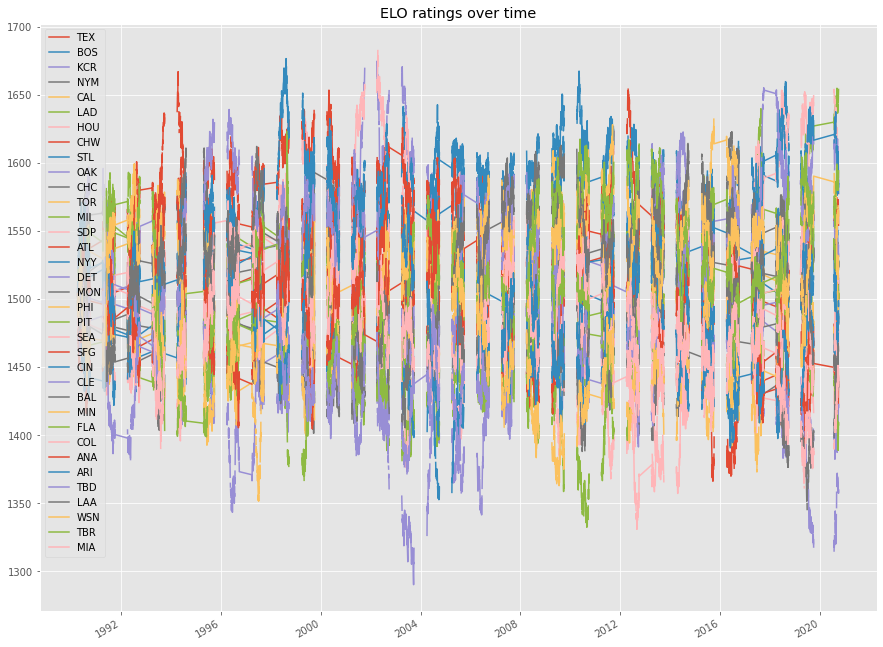

In [44]:
elo.plot.line(title='ELO ratings over time', figsize=(15, 12))

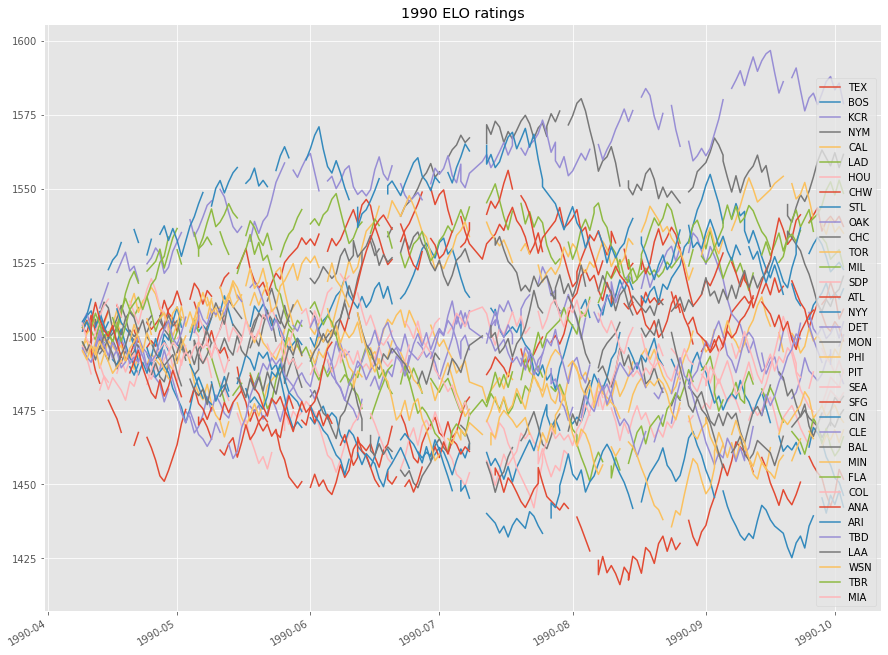

In [46]:
elo[elo.index.year == 1990].plot.line(title='1990 ELO ratings', figsize=(15, 12))

Let's look at the 2019 season.

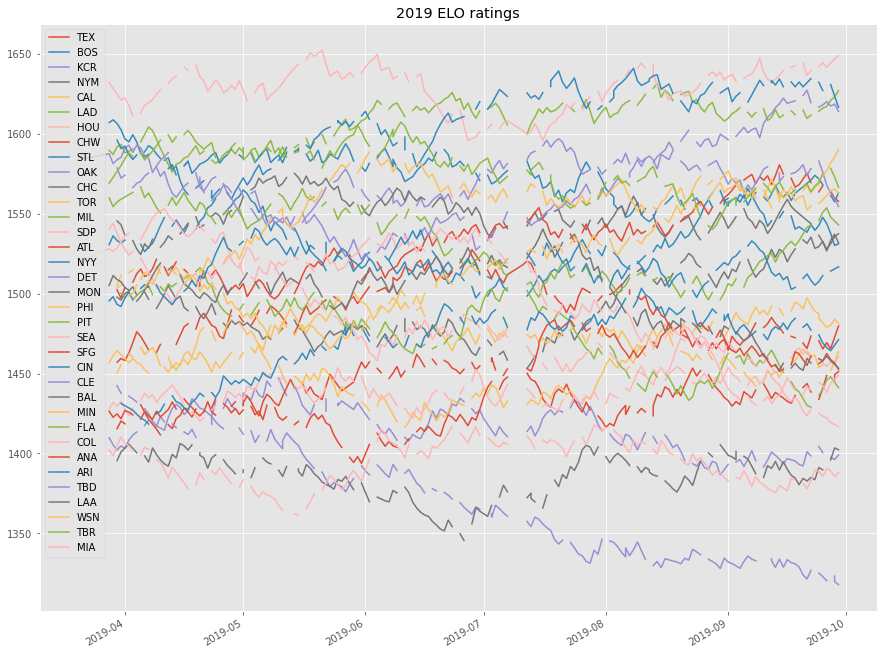

In [47]:
elo.loc[elo.index.year == 2019].plot.line(title='2019 ELO ratings', figsize=(15, 12))

The 2019 world series was between washington and houston. Looking at the ELO ratings, we see that they eneded the season with the highest ELO.

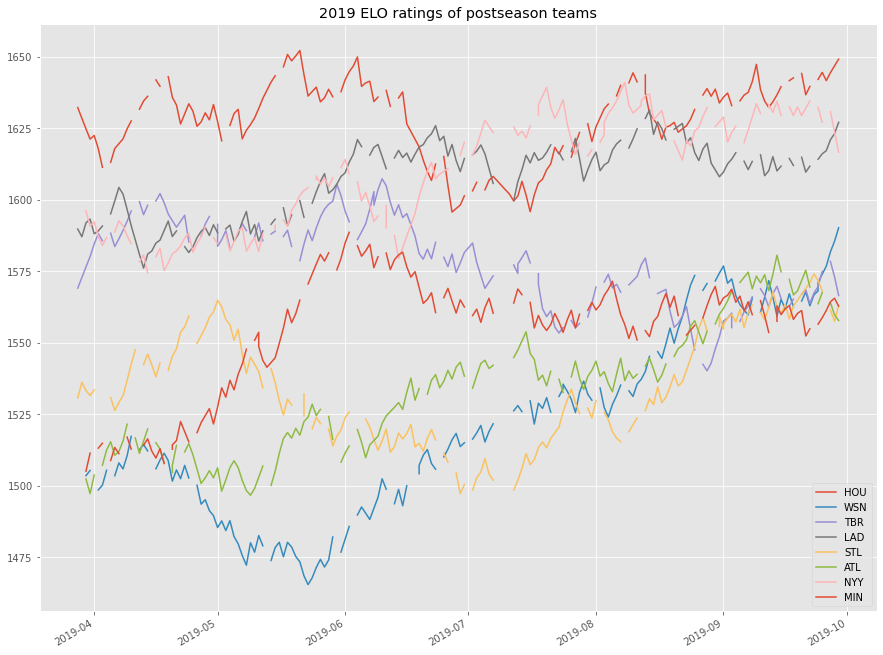

In [48]:
postseson_teams_2019 = ['HOU', 'WSN', 'TBR', 'LAD', 'STL', 'ATL', 'NYY', 'MIN']
elo.loc[elo.index.year == 2019, postseson_teams_2019].plot.line(title='2019 ELO ratings of postseason teams', figsize=(15, 12))

We can do the same for 2018.

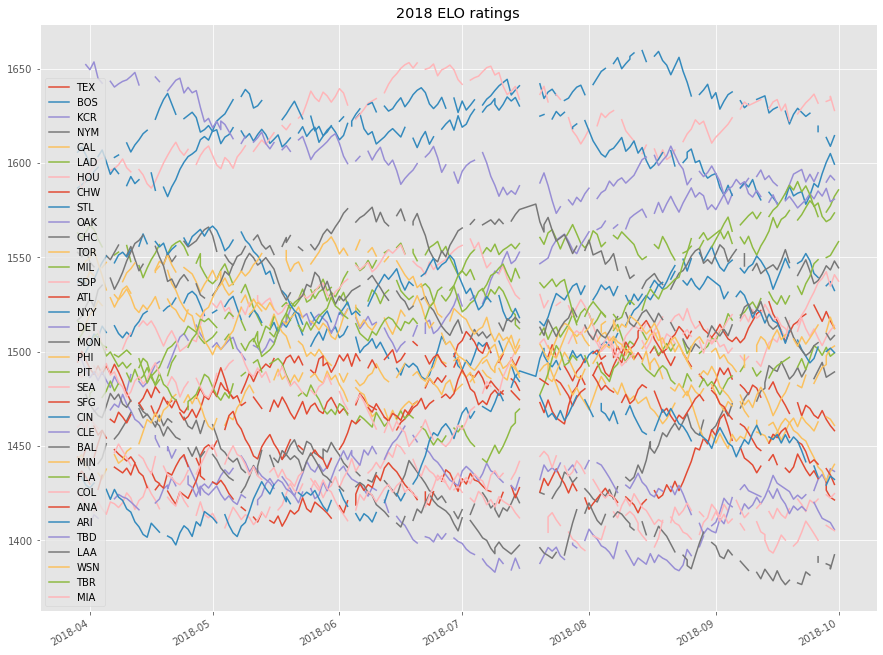

In [49]:
elo[elo.index.year == 2018].plot.line(title='2018 ELO ratings', figsize=(15, 12))

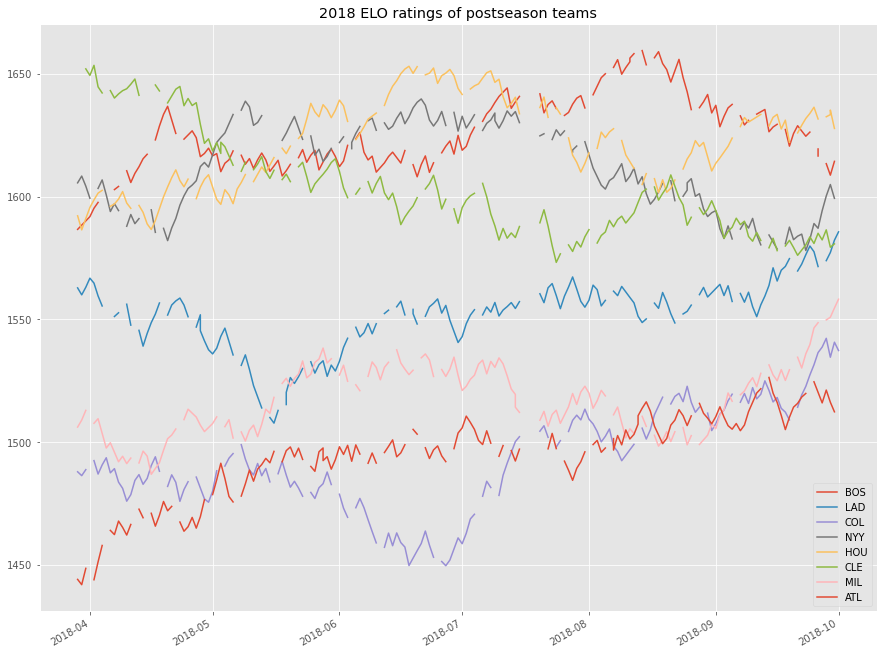

In [50]:
postseson_teams_2018 = ['BOS', 'LAD', 'COL', 'NYY', 'HOU', 'CLE', 'MIL', 'ATL']
elo.loc[elo.index.year == 2018, postseson_teams_2018].plot.line(title='2018 ELO ratings of postseason teams', figsize=(15, 12))

# References

- [Fangraphs post comparing ELO with regression.](https://tht.fangraphs.com/elo-vs-regression-to-the-mean-a-theoretical-comparison/)
- [Old Nate Solver post about ELO.](https://www.baseballprospectus.com/news/article/5247/lies-damned-lies-we-are-elo/)
- [538's desciption of their ELO model](https://fivethirtyeight.com/features/how-our-mlb-predictions-work/)